In [18]:
import re
import os
import sys
import datetime
import itertools
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.tsa.api as smt

from matplotlib.pylab import rcParams
plt.rcParams['savefig.dpi'] = 250
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"

pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)

import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

import statsmodels.formula.api as smf
import statsmodels.api as sm

import scipy.stats as scs
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image
from datetime import datetime

from math import sqrt
from sklearn.metrics import mean_squared_error

# Visualizar la demanda como serie de tiempo

In [19]:
#serie de tiempo en grafico
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

#leer la data del excel de los huespedes.csv
demand_data = pd.read_csv('./data/DemandaInfo.csv', parse_dates=['time'], index_col='time',date_parser=dateparse)

#guardar en otra variable
demand_ts = sales_data['demand']

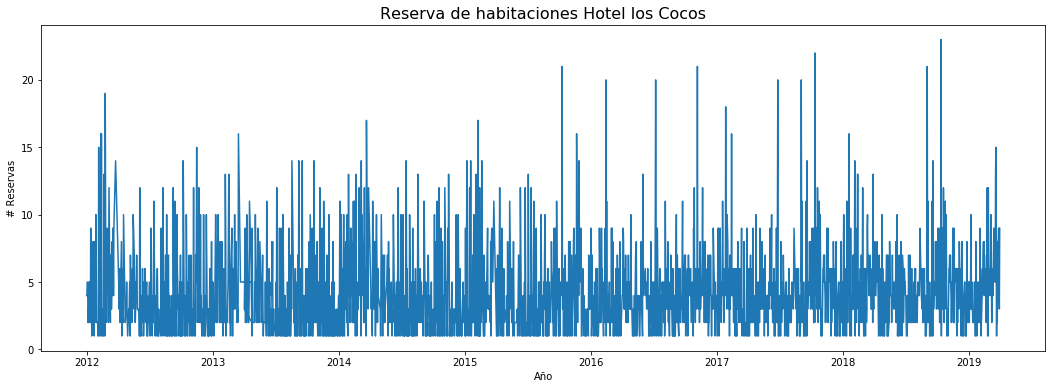

In [20]:
#imprimir la serie de tiempo
plt.plot(demand_ts, linewidth=1.5)
plt.title('Reserva de habitaciones Hotel los Cocos', fontsize=16)
plt.ylabel('# Reservas')
plt.xlabel('Año')
plt.show()

In [21]:
#agrupamos los dias por meses
demand_ts  = demand_data['demand'].resample('MS').sum()

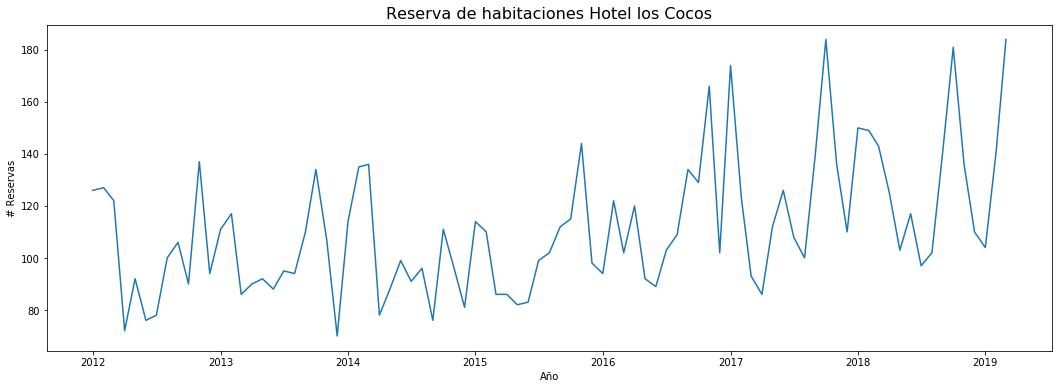

In [22]:
#imprimir la serie de tiempo
plt.plot(demand_ts, linewidth=1.5)
plt.title('Reserva de habitaciones Hotel los Cocos', fontsize=16)
plt.ylabel('# Reservas')
plt.xlabel('Año')
plt.show()

### Trend - Time Series Decomposition

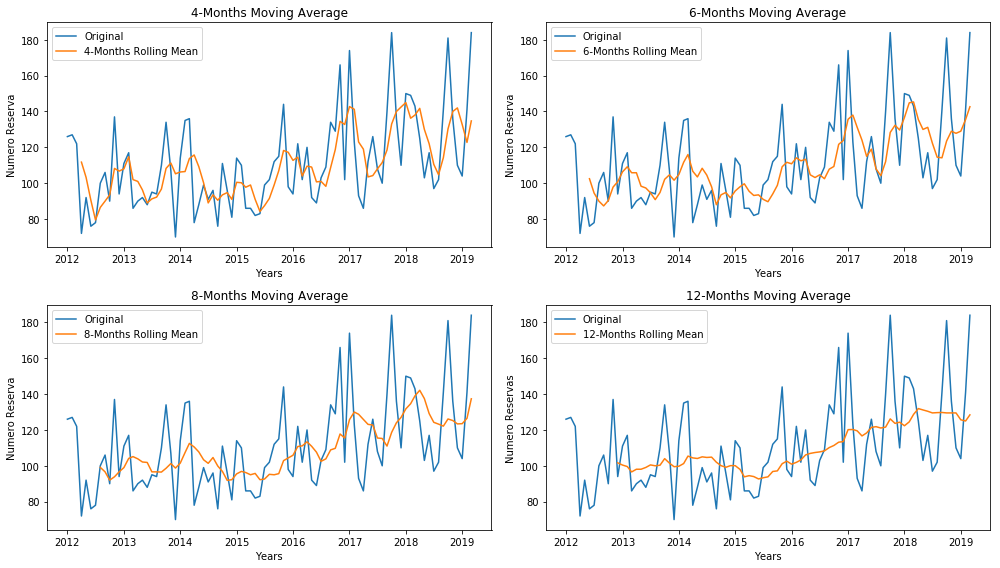

In [23]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)
axes[0][0].plot(demand_ts.index, demand_ts, label='Original')
axes[0][0].plot(demand_ts.index, demand_ts.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Numero Reserva")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')
axes[0][1].plot(demand_ts.index, demand_ts, label='Original')
axes[0][1].plot(demand_ts.index, demand_ts.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Numero Reserva")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')
axes[1][0].plot(demand_ts.index, demand_ts, label='Original')
axes[1][0].plot(demand_ts.index, demand_ts.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Numero Reserva")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')
axes[1][1].plot(demand_ts.index, demand_ts, label='Original')
axes[1][1].plot(demand_ts.index, demand_ts.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Numero Reservas")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')
plt.tight_layout()
plt.show()

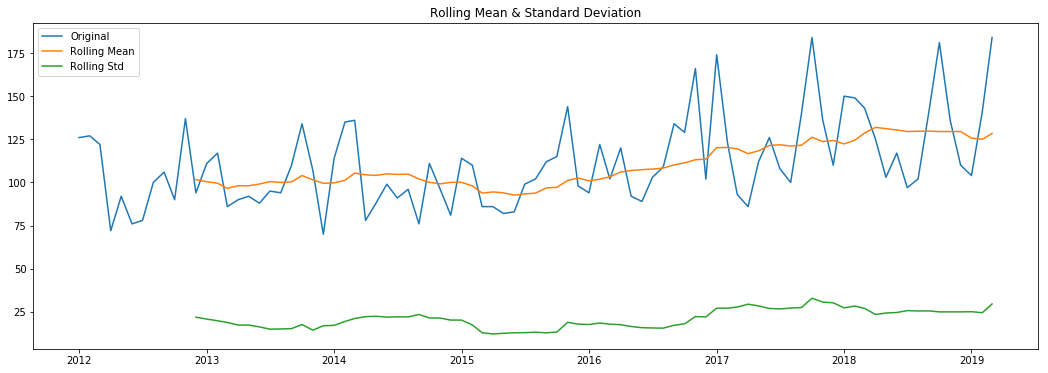

In [24]:
#Determing rolling statistics
rolmean = demand_ts.rolling(window=12).mean()
rolstd = demand_ts.rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(demand_ts, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean')
std = plt.plot(rolstd, label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [25]:
# Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(demand_ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -0.20853
p-value                        0.93750
#lags Used                    11.00000
Number of Observations Used   75.00000
Critical Value (1%)           -3.52071
Critical Value (5%)           -2.90092
Critical Value (10%)          -2.58778
dtype: float64


### Seasonality – Time Series Decomposition

In [26]:
monthly_demand_data = pd.pivot_table(demand_data, values = "demand", columns = "year", index = "month" ,aggfunc=[np.sum])
monthly_demand_data = monthly_demand_data.reindex(index = ['ENE','FEB','MAR', 'ABR', 'MAY', 'JUN', 'JUL', 'AGO', 'SEPT', 'OCT', 'NOV', 'DIC'])
monthly_demand_data

sum                                                              \
year       2012      2013      2014      2015      2016      2017      2018   
month                                                                         
ENE   126.00000 111.00000 114.00000 114.00000  94.00000 174.00000 150.00000   
FEB   127.00000 117.00000 135.00000 110.00000 122.00000 123.00000 149.00000   
MAR   122.00000  86.00000 136.00000  86.00000 102.00000  93.00000 143.00000   
ABR    72.00000  90.00000  78.00000  86.00000 120.00000  86.00000 125.00000   
MAY    92.00000  92.00000  88.00000  82.00000  92.00000 112.00000 103.00000   
JUN    76.00000  88.00000  99.00000  83.00000  89.00000 126.00000 117.00000   
JUL    78.00000  95.00000  91.00000  99.00000 103.00000 108.00000  97.00000   
AGO   100.00000  94.00000  96.00000 102.00000 109.00000 100.00000 102.00000   
SEPT  106.00000 110.00000  76.00000 112.00000 134.00000 140.00000 141.00000   
OCT    90.00000 134.00000 111.00000 115.00000 129.00000 184.00000 181.00000   
NOV   137.00000 107.00000  96.00000 144.00000 166.00000 136.00000 136.00000   
DIC    94.00000  70.00000  81.00000  98.00000 102.00000 110.00000 110.00000   

                 
year       2019  
month            
ENE   104.00000  
FEB   141.00000  
MAR   184.00000  
ABR         nan  
MAY         nan  
JUN         nan  
JUL         nan  
AGO         nan  
SEPT        nan  
OCT         nan  
NOV         nan  
DIC         nan

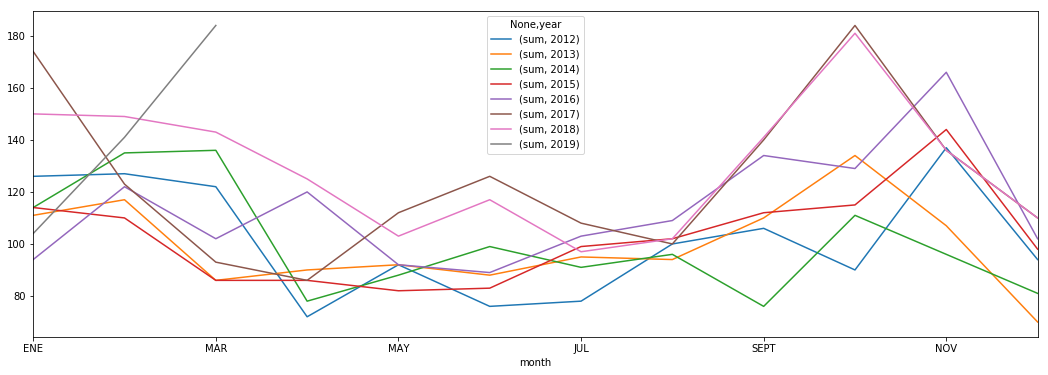

In [27]:
monthly_demand_data.plot()

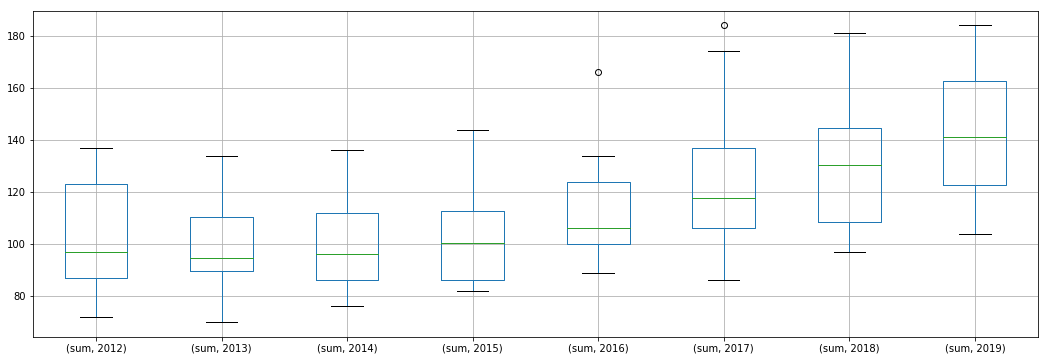

In [28]:
monthly_demand_data.boxplot()

### Irregular Remainder – Time Series Decomposition

In [29]:
decomposition = sm.tsa.seasonal_decompose(demand_ts, model='additive')

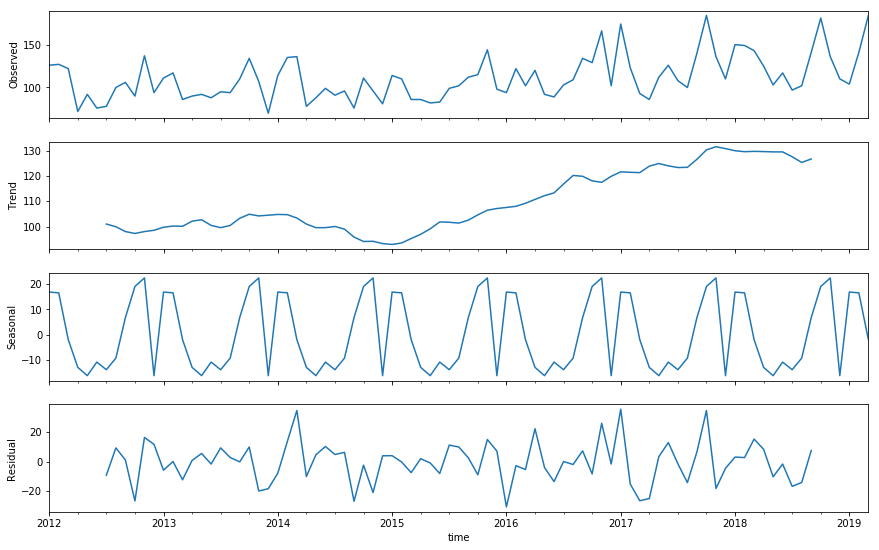

In [30]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
plt.show()

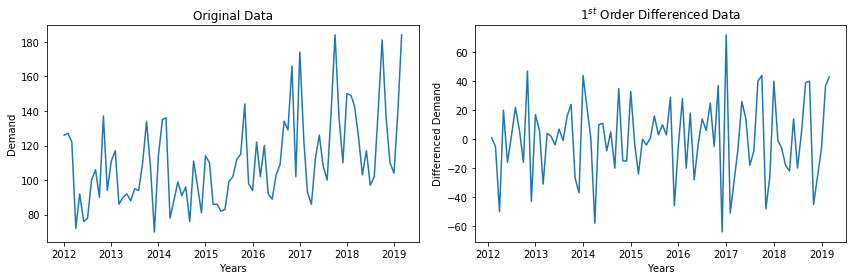

In [32]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
axes[0].plot(demand_ts.index, demand_ts)
axes[0].set_xlabel("Years")
axes[0].set_ylabel("Demand")
axes[0].set_title("Original Data")
axes[1].plot(demand_ts.index, demand_ts.diff(periods=1))
axes[1].set_xlabel("Years")
axes[1].set_ylabel("Differenced Demand")
axes[1].set_title("1$^{st}$ Order Differenced Data")
plt.tight_layout()
plt.show()

### Diferenciar los datos para hacer que sean estacionarios en la media (eliminar tendencia) 

Text(0, 0.5, 'Demand')

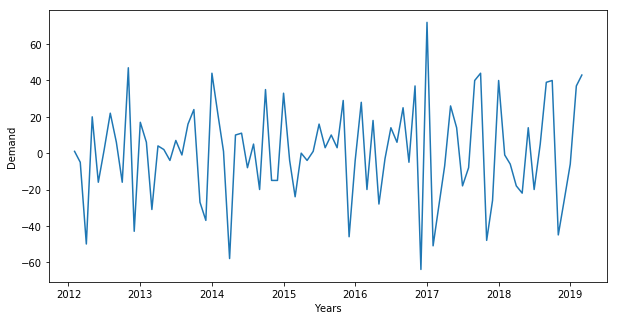

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(demand_ts.diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Demand')

### Log transformation para hacer que los datos sean estacionarios en varianza 

Text(0, 0.5, 'Log (Demand)')

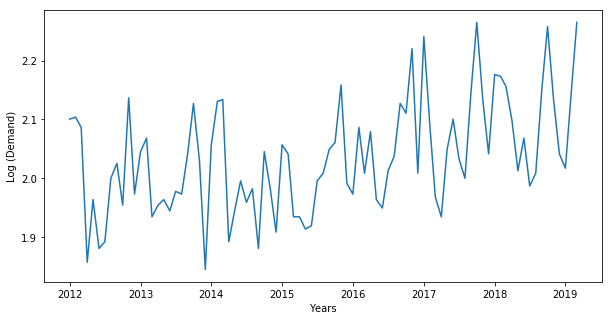

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(demand_ts))
plt.xlabel('Years')
plt.ylabel('Log (Demand)')

### Difference log transform para hacer que los datos sean estacionarios tanto en la media como en varianza

Text(0, 0.5, 'Differenced Log (Tractor Sales)')

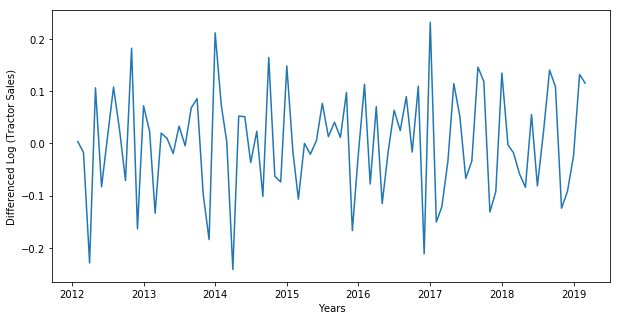

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(np.log10(demand_ts).diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Differenced Log (Tractor Sales)')

### Plot ACF and PACF to identify potential AR and MA model

In [37]:
demand_ts_log = np.log10(demand_ts)
demand_ts_log.dropna(inplace=True)

demand_ts_log_diff = demand_ts_log.diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
demand_ts_log_diff.dropna(inplace=True)

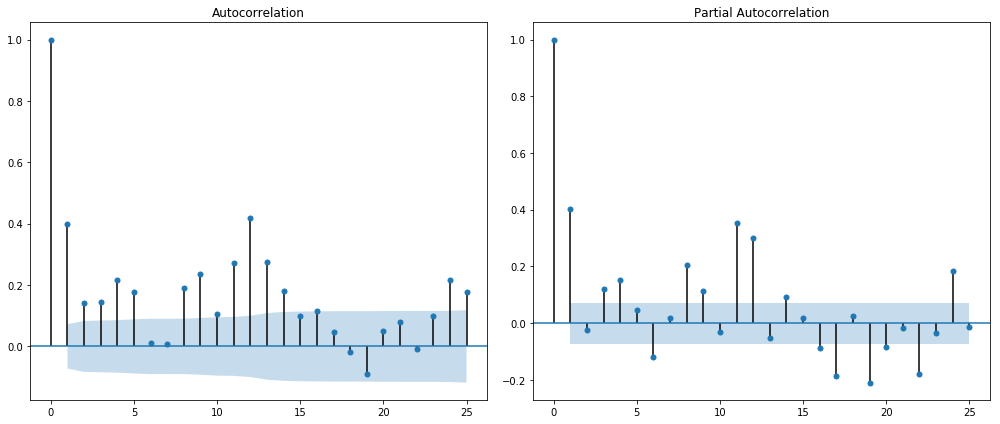

In [40]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(6)
smt.graphics.plot_acf(demand_ts_log, lags=25, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(demand_ts_log, lags=25, ax=axes[1], alpha=0.5)
plt.tight_layout()

### Identificación del mejor modelo de ajuste ARIMA 

In [41]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [42]:
import sys
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(demand_ts_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(0, 1, 1)x(1, 0, 1, 12)12 model - AIC:-188.7368703102497


In [43]:
best_model = sm.tsa.statespace.SARIMAX(demand_ts_log,
                                      order=(0, 1, 1),
                                      seasonal_order=(1, 0, 1, 12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
best_results = best_model.fit()

In [44]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])
print(best_results.summary().tables[2])

                                 Statespace Model Results                                 
Dep. Variable:                             demand   No. Observations:                   87
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                  81.740
Date:                            Thu, 20 Jun 2019   AIC                           -155.479
Time:                                    23:47:41   BIC                           -146.373
Sample:                                01-01-2012   HQIC                          -151.854
                                     - 03-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8762      0.075    -11.676      0.000      -1.023      -0.729
ar.S.L12       0.8613      0.086   

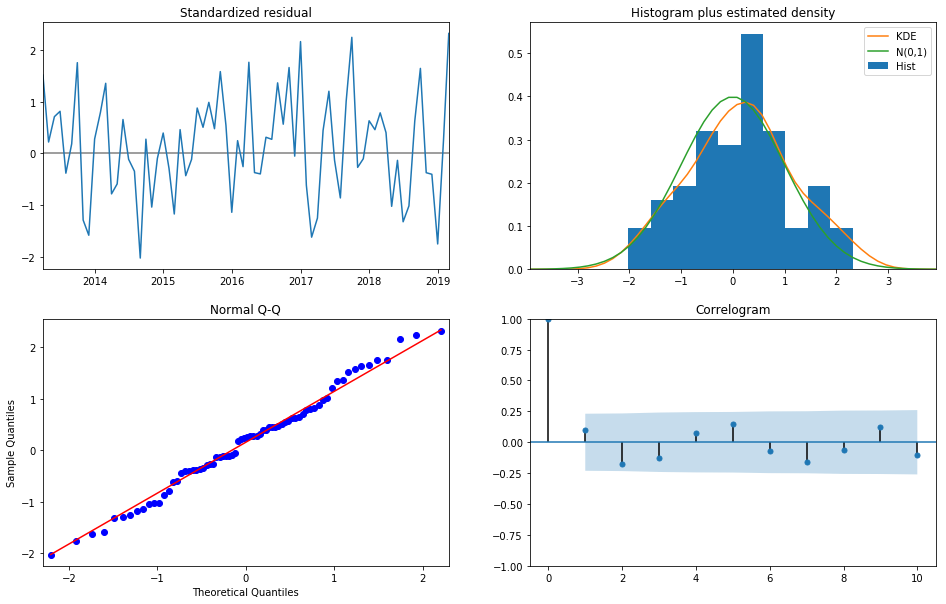

In [45]:
best_results.plot_diagnostics(figsize=(16, 10))
plt.show()

### Predict demand on in-sample date using the best fit ARIMA model

In [57]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2014-01-01'), dynamic=False, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [107]:
# Extract the predicted and true values of our time series
demand_ts_forecasted = pred_dynamic.predicted_mean
demand_ts_truth = demand_ts_log['2014-01-01':]



The Mean Squared Error of our forecasts is 0.0055
The of our forecasts is -0.0043


In [109]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [112]:
mad = demand_ts_forecasted.mad()
mad

0.051795539639469014

In [111]:
# Mean square error
mse = ((demand_ts_forecasted - demand_ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

mape = mean_absolute_percentage_error(demand_ts_truth, demand_ts_forecasted)
print('The mean_absolute_percentage_error of our forecasts is {}'.format(round(mape, 4)))

The Mean Squared Error of our forecasts is 0.0055
The mean_absolute_percentage_error of our forecasts is 2.8631


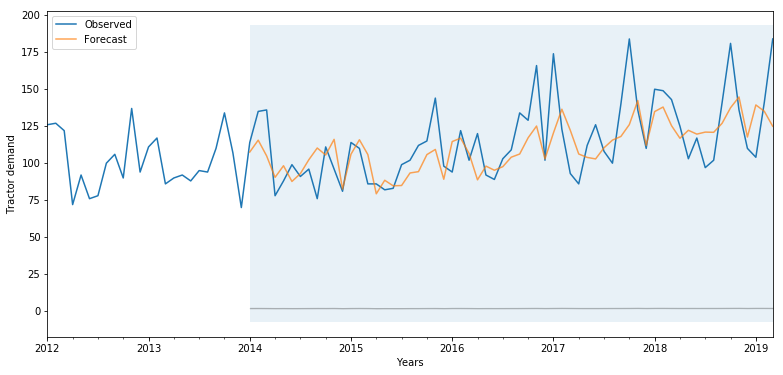

In [75]:
axis = demand_ts['2012':].plot(label='Observed', figsize=(13, 6))
np.power(10, pred_dynamic.predicted_mean).plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)
axis.fill_betweenx(axis.get_ylim(), pd.to_datetime('2014-01-01'), demand_ts.index[-1], alpha=.1, zorder=-1)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor demand')
plt.legend(loc='best')
plt.show()
plt.close()

### Forecast sales using the best fit ARIMA model

In [99]:
# Get forecast 24 steps (3 years) ahead in future
n_steps = 24
pred_uc_99 = best_results.get_forecast(steps=24, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=24, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [100]:
n_steps = 24
idx = pd.date_range(demand_ts.index[-1], periods=n_steps, freq='MS')

fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])

fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])

fc_all = fc_95.combine_first(fc_99)

fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head(15)

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2019-03-01,121.04281,87.25981,167.90506,87.25981,167.90506
2019-04-01,121.67425,87.49649,169.20249,87.49649,169.20249
2019-05-01,123.47238,88.56999,172.12861,88.56999,172.12861
2019-06-01,122.14041,87.39949,170.69069,87.39949,170.69069
2019-07-01,125.30061,89.44237,175.53475,89.44237,175.53475
2019-08-01,137.05132,97.59363,192.46199,97.59363,192.46199
2019-09-01,148.18303,105.26703,208.59534,105.26703,208.59534
2019-10-01,145.29482,102.96910,205.01864,102.96910,205.01864
2019-11-01,122.19710,86.39482,172.83593,86.39482,172.83593
2019-12-01,138.64602,97.79380,196.56379,97.79380,196.56379


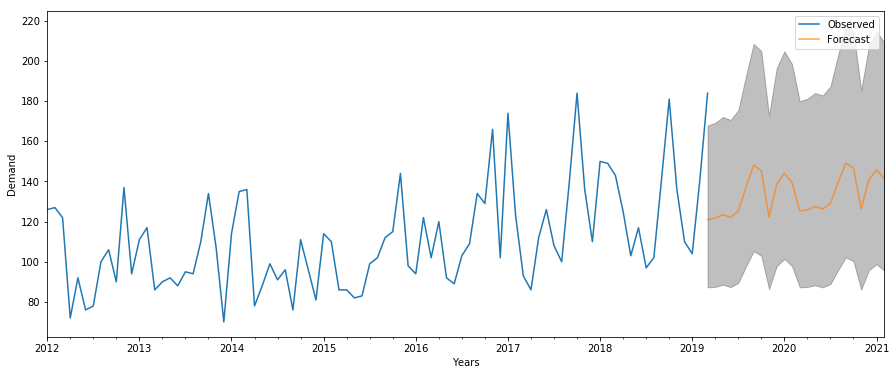

In [101]:
# plot the forecast along with the confidence band
axis = demand_ts.plot(label='Observed', figsize=(15, 6))

fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)

axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.25)

#axis.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)
#axis.fill_betweenx(axis.get_ylim(), pd.to_datetime('2014-01-01'), demand_ts.index[-1], alpha=.1, zorder=-1)
#axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color='red', alpha=.75)

axis.set_xlabel('Years')
axis.set_ylabel('Demand')
plt.legend(loc='best')
plt.show()

In [105]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(demand_ts_truth)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(demand_ts_forecasted, demand_ts_truth)

{'mape': 0.02863086456358586,
 'me': -0.011189088828303728,
 'mae': 0.05924257922937895,
 'mpe': -0.004266284796541079,
 'rmse': 0.07382828121795375,
 'acf1': 0.42355660812242485,
 'corr': 0.6377303629773694,
 'minmax': 0.028133757858607833}